# SARIMAX and Baseline Modeling

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
import holidays

# Machine learning basics
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn import datasets, linear_model

# Stats packages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


# Settings
plt.style.use('seaborn-deep')
import warnings
warnings.filterwarnings("ignore")

Certainly, we have to prepare the data first.

In [2]:
ts = pd.read_csv("cleaned-daily.csv", parse_dates = ['Date'])
ts = ts.set_index('Date')[["kWh"]].sort_index().asfreq('d')
ts.head(15)

,kWh
Date,
2017-01-01,399131.94
2017-01-02,545259.57
2017-01-03,557400.78
2017-01-04,557394.31
2017-01-05,554266.71
2017-01-06,484772.87
2017-01-07,448601.37
2017-01-08,433151.95
2017-01-09,638036.96


<AxesSubplot:xlabel='Date'>

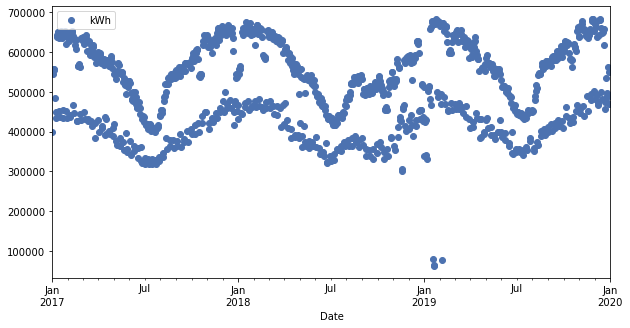

In [3]:
ts.plot(figsize=(10,5),style="o")

We start with splitting the data into train set and test set. To make the problem more challenging, we intentionally design our test set to be overlapping with the winter holiday season, which can help us more accurately judge the performance of the models during the strong presence of consecutive outliers.

In order to view both the in-sample and out-of-sample prediction, a part of the time series that contain both the data from the test set and train set is set aside, called demo. We will plot on the demo set in the end of this section.  

<AxesSubplot:xlabel='Date'>

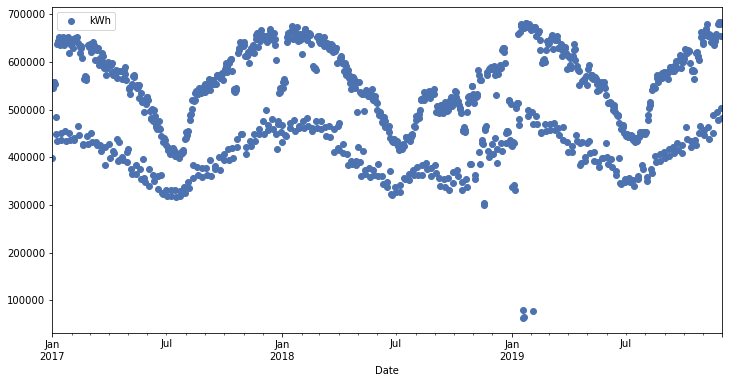

In [4]:
train_end = '2019-12-01'
test_end = '2020-01-01'
demo_start = '2019-11-25'
demo = ts[demo_start:test_end]
train,test = ts[:train_end], ts[train_end:]

train.plot(figsize=(12,6), style = 'o')

## Baseline model

In every modeling process, there needs to be a baseline model whose results can be used to assess our protagonist models and their results. Such a model should be easy to implement and can provide an adequate result. Therefore, a simple linear regression model, in this case, would suffice.

Mathematically, we can formulate the equation for this regression as follow
$$
y_t = \beta_0 + \beta_1 t + \epsilon_t,
$$
where $y_t$ is the data, and $t$ is the date time. 

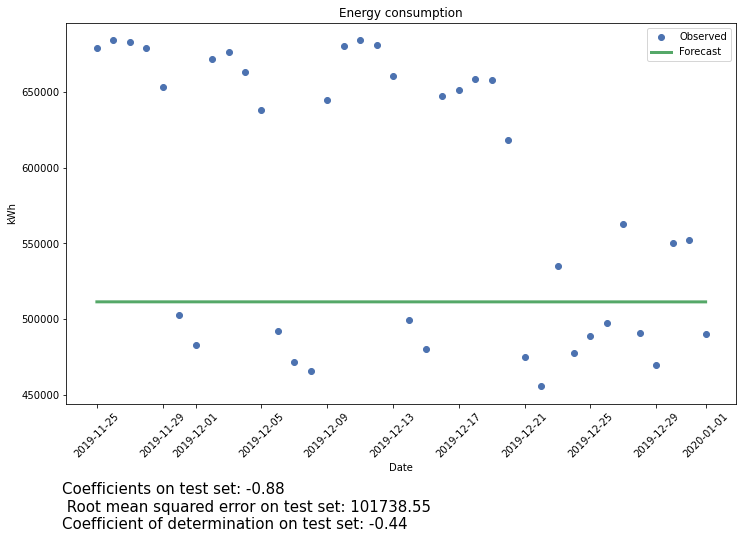

In [5]:
from math import sqrt

X = (train.index - train.index[0]).days.values.reshape(-1, 1)
y = train.kWh.values.reshape(-1, 1)

X_demo = (demo.index - train.index[0]).days.values.reshape(-1,1)
y_demo = demo.kWh.values.reshape(-1, 1)

X_test = (test.index - train.index[0]).days.values.reshape(-1,1)
y_test = test.kWh.values.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(X,y)

regr_pred_demo = regr.predict(X_demo)
regr_pred_test = regr.predict(X_test)

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', xlabel='Date', ylabel='kWh')

ax.plot(demo.index, y_demo,'o')
ax.plot(demo.index, regr_pred_demo, linewidth=3)

err = 'Coefficients on test set: ' + str(round(regr.coef_.take(0).take(0),2)) + '\n Root mean squared error on test set: ' + \
    str(round(sqrt(MSE(y_test, regr_pred_test)),2)) + '\nCoefficient of determination on test set: ' + \
        str(round(r2_score(y_test, regr_pred_test), 2))

plt.figtext(0.12, -0.08, err, ha="left",fontsize=15,va='center')
plt.xticks(rotation=45)
legend = ax.legend(["Observed", "Forecast"])

Now, we know that we need to do much better than a root mean squared error of 101,738 kWh!

## SARIMAX

### Model Identification
Moving on to predicting the time series using SARIMAX models. Theoretically, they are simply combinations of Seasonal ARIMA with exogenous variables, which improves outliers modeling. One shorthand notation for the SARIMA model is
$$
\text{SARIMA } (p,d,q) \times (P,D,Q)S,
$$
where $p$ = non-seasonal autoregressive (AR) order, $d$ = non-seasonal differencing, $q$ = non-seasonal moving average (MA) order, $P$ = seasonal AR order, $D$ = seasonal differencing, $Q$ = seasonal MA order, and $S$ = time span of repeating seasonal pattern. Fitting time series using ARIMA models is known as the Box-Jenkins method.

In order to apply the model, we first need to guarantee that the time series is stationary, or can be transformed into a stationary one. To simply put, a stationary time series is one whose properties is not dependent on time, with the mean, variance and autocorrelation structure do not change over time.

We can see from the initial plot that the time series is clearly not stationary, with visible seasonality and possibly trend. However, to be more scientific, we can employ various stationarity tests. Here, the one we used is the [Dickey-Fuller test](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), which is one of the more commonly-used ones.

In [6]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=14, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts.kWh)

Results of Dickey-Fuller Test:
Test Statistic                   -2.519272
p-value                           0.110855
#Lags Used                       14.000000
Number of Observations Used    1081.000000
Critical Value (1%)              -3.436414
Critical Value (5%)              -2.864217
Critical Value (10%)             -2.568196
dtype: float64


We can see that the p-value is bigger than $\alpha = 0.05$. Therefore, the time series is expectedly not stationary.  

In order to stationarize the data, we need to remove the trend and seasonal components. We can do that by differencing the data by the desired order of differencing. Intuitively, this is analogous to taking the derivatives of functions.

<AxesSubplot:xlabel='Date'>

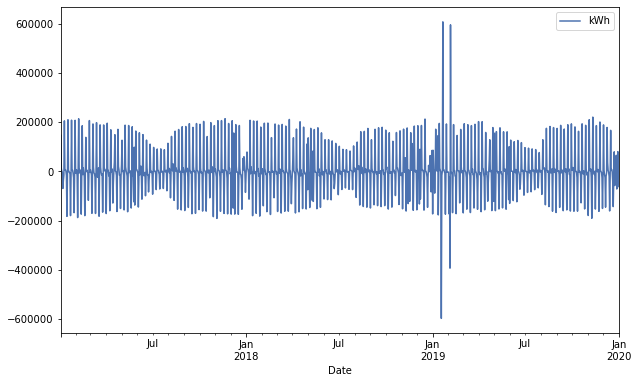

In [7]:
# invert differenced forecast
def invert_diff(series, first_element_before):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_original

diffed = diff(ts,seasonal_periods=7)
diffed.plot(figsize=(10,6))

Now, the data looks much more appropriate for SARIMAX modeling. We can check again with the [Dickey-Fuller test](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html).

In [8]:
test_stationarity(diffed.kWh)

Results of Dickey-Fuller Test:
Test Statistic                -1.287184e+01
p-value                        4.860589e-24
#Lags Used                     1.400000e+01
Number of Observations Used    1.080000e+03
Critical Value (1%)           -3.436419e+00
Critical Value (5%)           -2.864220e+00
Critical Value (10%)          -2.568197e+00
dtype: float64


Since the p-value is much smaller than $\alpha = 0.05$, the differenced time series is stationary.

We now proceed to check the correlation structure within the transformed data using [Autocorrelation Function (ACF)](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html) and [Partial Autocorrelation Function (PACF)](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html) plots. This step is crucial in order to identify the suitable order of the AR and MA terms, both non-seasonal and seasonal.

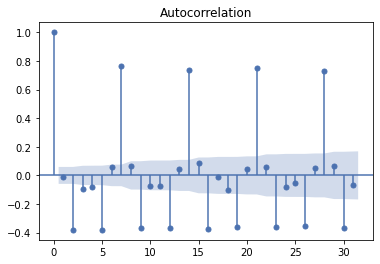

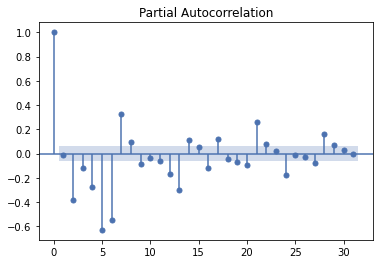

In [9]:
acf = plot_acf(diffed)
pacf = plot_pacf(diffed)

From the plots, a complex pattern with unexpected increases and decreases in the values of the functions can be found. Therefore, we cannot preclude any orders for the AR and MA terms. 

With regards to the seasonal terms, the plots show expected behaviours with spikes at lags equals to the number of days in a week. It can be hypothesized that P = 1 and Q = 2. Let us check our guesses in the next section where we apply the model.

### Model Estimation

For the exogenous variables, one prime candidate is the date of holidays in Finland. We can procure such data using the [holidays package](https://pypi.org/project/holidays/).

In [10]:
begin = '2017-01-01'
abv = '2019-12-31'
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:abv])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1

exo.drop(["kWh"],axis=1,inplace=True)
exo_train,exo_test = exo[:train_end],exo[train_end:abv]
exo_test[:10]

,holidays
Date,
2019-12-01,0
2019-12-02,0
2019-12-03,0
2019-12-04,0
2019-12-05,0
2019-12-06,1
2019-12-07,0
2019-12-08,0
2019-12-09,0


Now we can finally get to apply the model. In order to expedite the process, we can use the Grid Search method, which involves experimenting with many different parameters and comparing them using a loss function. For ARIMA models, Akaike Information Criterion (AIC) is a widely used estimator, and we will also use it for this task. 

In [11]:
def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], res.aic))
        except Exception as e:
            print(e)
            continue
            
    return results

In [12]:
# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(train,exo_train,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:32564.88050616446
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:25731.529440173726
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 7) - AIC:25722.91192426073
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:26056.160873775152
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:25717.072855556908
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 7) - AIC:25699.999106262865
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 7) - AIC:25911.0475681841
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 7) - AIC:25696.633328530184
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 7) - AIC:25693.365379976975
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:26126.817463606545
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 7) - AIC:25723.41516956192
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 7) - AIC:25711.22525120811
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC:25933.949666732606
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 7) - AIC:25711.618774761067
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 7) - AIC:25713.194796136988
Tried out SARIMAX(0, 1, 1)x(2, 

We can see that there is not a big variation between the AICs, i.e. most of the models are of similar quality. Let us list the estimated best models.

In [13]:
all_res.sort(key=lambda x: x[1])
all_res[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2488fba3640>,
  25676.268889184914,
  ((2, 1, 1), (0, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x24897e747f0>,
  25676.797025383818,
  ((2, 1, 1), (1, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2489edb6970>,
  25678.120812001267,
  ((2, 1, 1), (1, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x248a91fa7f0>,
  25678.35461926466,
  ((2, 1, 1), (2, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x247bece6730>,
  25678.646468260253,
  ((2, 1, 2), (0, 1, 2, 7)))]

According to the AIC score, the best model to choose is
$$
\text{SARIMA } (2,1,1) \times (0,1,2)7.
$$

## Model Validation

To determine the goodness of fit of the model, we can examine its residuals using the standard assumption. That is the error term $\epsilon_t$ should be white noise drawings from a fixed distribution with a constant mean and variance.

We can check this by looking at the various plots showing the distribution of the residuals. In addition, the Ljung-box test can also be used to do this more precisely. 

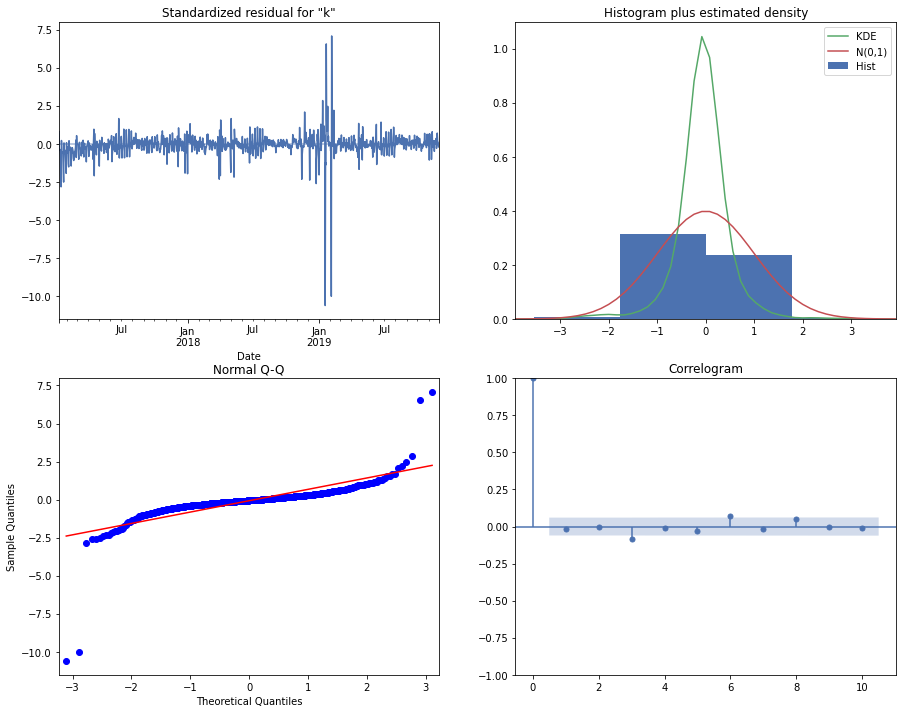

Ljung-box p-values:
[0.65436231 0.90463622 0.06795877 0.12472437 0.14740367 0.03968836
 0.06185646 0.03838283 0.06022391 0.08706991 0.09227044 0.10574783
 0.14476614 0.1221166 ]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    kWh   No. Observations:                 1065
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood              -12831.134
Date:                                Sat, 16 Jan 2021   AIC                          25676.269
Time:                                        18:43:36   BIC                          25711.011
Sample:                                    01-01-2017   HQIC                         25689.438
                                         - 12-01-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holidays   -7.071e+04   1.04e+04     -6.829      0.000    -9.1e+04   -5.04e+04
ar.L1          0.4999      0.059      8.420      0.000       0.384       0.616
ar.L2          0.0470      0.041      1.149      0.250      -0.033       0.127
ma.L1         -0.8441      0.067    -12.654      0.000      -0.975      -0.713
ma.S.L7       -0.8361      0.028    -29.707      0.000      -0.891      -0.781
ma.S.L14      -0.1456      0.022     -6.719      0.000      -0.188      -0.103
sigma2      3.114e+09      0.152   2.05e+10      0.000    3.11e+09    3.11e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):            286558.46
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                            -3.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        83.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+25. Standard errors may be unstable.
"""

In [14]:
res = all_res[0][0]
res.plot_diagnostics(figsize=(15, 12))

plt.show()
print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

From the plots, the residuals seem to be normally distributed around 0 - which is the condition that we need - with slightly heavy tails. However, looking at the Ljung box statistics, we cannot reject the hypothesis that the data are not independently distributed, since the p-values are smaller than $\alpha = 0.05$ for some lags from 6 to 8. 

Nevertheless, let us use this model to predict on the test set and judge it for ourselves.

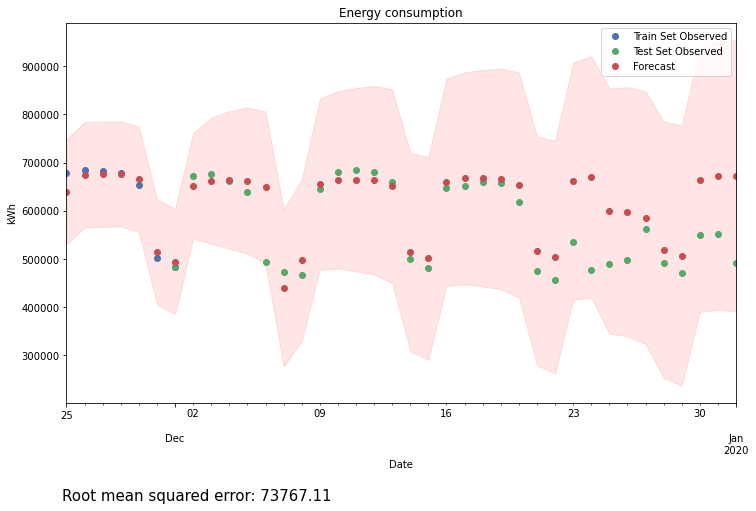

In [15]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)

# The mean squared error
err = 'Root mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = res.get_prediction(start=demo_start,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', ylabel='kWh')

train[demo_start:].plot(ax=ax, style='o')
test.plot(ax=ax, style='o')
pred.predicted_mean.plot(ax=ax, style='o')
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])

The result looks very satisfactory! During the first 2 weeks of the month, the forecasted values fit well to the actual ones, possibly with the exception of the 6th of December - the Independence day of Finland.

With regards to the winter holiday season, the model unfortunately did not do as well. Contrary to the first 2 weeks, the only day where the values are more accurately predicted is the 27th, despite the addition of the "holiday" variable. This shows the challenges of forecasting during exceptional time periods. Nevertheless, the model still show promises in forecasting when the data behaves predictably.